In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format',lambda x:'%.5f'%x)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_QyjYwdj.csv")
campaign = pd.read_csv("campaign_data.csv",parse_dates=['start_date','end_date'],dayfirst=True)
mapping = pd.read_csv("coupon_item_mapping.csv")
demographics = pd.read_csv("customer_demographics.csv")
transactions = pd.read_csv("customer_transaction_data.csv",parse_dates=['date'])
item = pd.read_csv("item_data.csv")

In [3]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
id                   78369 non-null int64
campaign_id          78369 non-null int64
coupon_id            78369 non-null int64
customer_id          78369 non-null int64
redemption_status    78369 non-null int64
dtypes: int64(5)
memory usage: 3.0 MB


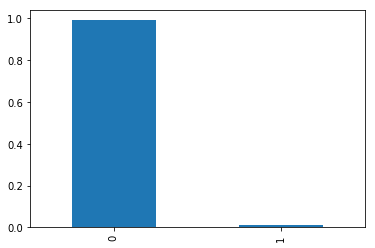

In [5]:
train.redemption_status.value_counts(dropna=False,normalize=True).plot(kind='bar')
# The data is too imbalanced as we can see below.

In [6]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,2013-10-21,2013-12-20
1,25,Y,2013-10-21,2013-11-22
2,20,Y,2013-09-07,2013-11-16
3,23,Y,2013-10-08,2013-11-15
4,21,Y,2013-09-16,2013-10-18


In [7]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null datetime64[ns]
end_date         28 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 976.0+ bytes


In [8]:
mapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [9]:
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
coupon_id    92663 non-null int64
item_id      92663 non-null int64
dtypes: int64(2)
memory usage: 1.4 MB


In [10]:
demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [11]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    431 non-null object
rented            760 non-null int64
family_size       760 non-null object
no_of_children    222 non-null object
income_bracket    760 non-null int64
dtypes: int64(3), object(4)
memory usage: 41.6+ KB


In [12]:
transactions.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26000,-10.69000,0.00000
1,2012-01-02,1501,54253,1,53.43000,-13.89000,0.00000
2,2012-01-02,1501,31962,1,106.50000,-14.25000,0.00000
3,2012-01-02,1501,33647,1,67.32000,0.00000,0.00000
4,2012-01-02,1501,48199,1,71.24000,-28.14000,0.00000


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null datetime64[ns]
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [14]:
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [15]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
item_id       74066 non-null int64
brand         74066 non-null int64
brand_type    74066 non-null object
category      74066 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [16]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50226 entries, 0 to 50225
Data columns (total 4 columns):
id             50226 non-null int64
campaign_id    50226 non-null int64
coupon_id      50226 non-null int64
customer_id    50226 non-null int64
dtypes: int64(4)
memory usage: 1.5 MB


#### EDA Train Data

In [18]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [19]:
for col in train.columns:
    print ("Number of Unique Values in {} column in tranining data are:".format(col),train[col].nunique())

Number of Unique Values in id column in tranining data are: 78369
Number of Unique Values in campaign_id column in tranining data are: 18
Number of Unique Values in coupon_id column in tranining data are: 866
Number of Unique Values in customer_id column in tranining data are: 1428
Number of Unique Values in redemption_status column in tranining data are: 2


1. Train data has information about 1428 Unique Customers. 
2. Those 1428 customers are served with 866 Unique Coupons. 
3. There are totally 18 unique campaigns. 

Text(0.5,1,"Count Plot of Unique Campaign ID's served to customers.")

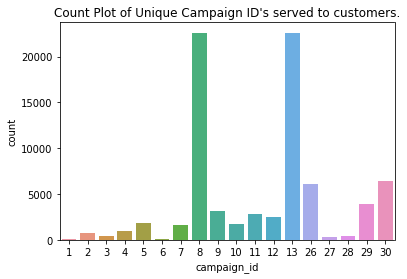

In [20]:
sns.countplot(train['campaign_id'])
plt.title("Count Plot of Unique Campaign ID's served to customers.")
# Campaigns 13 and 8 are mostly served.

In [21]:
train['customer_id'].value_counts().head()

1463    199
590     193
189     175
1192    173
464     171
Name: customer_id, dtype: int64

In [22]:
train.groupby('customer_id')['campaign_id'].nunique().sort_values(ascending=False).head()
# Customer with id 463 has been served with 11 out of 18 unique campaigns followed by 957 who is served with 10.

customer_id
1463    11
957     10
1192     9
1378     9
590      8
Name: campaign_id, dtype: int64

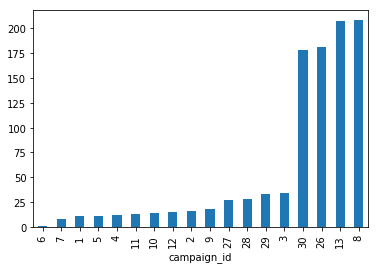

In [23]:
train.groupby('campaign_id')['coupon_id'].nunique().sort_values().plot(kind='bar')
# Count of Unique coupon_id's grouped by campaign_id. Campaign_id's 30,26,13 and 8 have highest number of coupon_id's under them.

In [24]:
train['coupon_id'].value_counts().head()

705     570
470     447
691     405
468     366
1043    357
Name: coupon_id, dtype: int64

In [25]:
train.groupby('customer_id')['coupon_id'].nunique().sort_values(ascending=False).head()

customer_id
1463    187
590     185
189     163
1192    163
63      159
Name: coupon_id, dtype: int64

In [26]:
train.groupby('campaign_id')['redemption_status'].value_counts().unstack().sort_values(by=0)
# As we can see below, all the 18 campaigns have atleast one coupon which is redeemed under it.

redemption_status,0,1
campaign_id,,
6,64,1
1,142,1
27,323,1
3,406,2
28,475,1
2,763,5
4,965,7
7,1580,4
10,1716,7


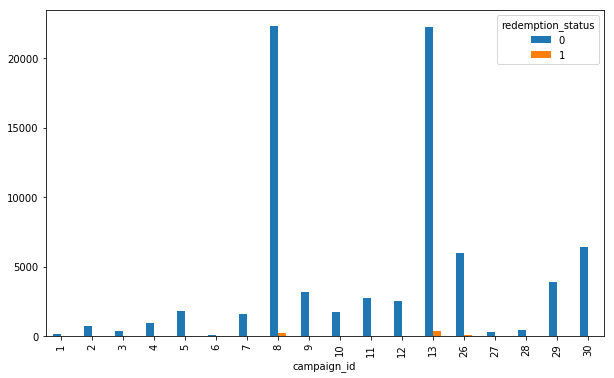

In [27]:
train.groupby('campaign_id')['redemption_status'].value_counts().unstack().plot(kind='bar',figsize=(10,6))

In [28]:
train.groupby('coupon_id')['redemption_status'].value_counts().unstack().sort_values(by=1)
# As we can see below, there are a lot of coupon_id's which have not been redeemed at all.

redemption_status,0,1
coupon_id,,
1102,197.00000,1.00000
911,154.00000,1.00000
669,213.00000,1.00000
667,165.00000,1.00000
666,69.00000,1.00000
665,29.00000,1.00000
662,122.00000,1.00000
916,136.00000,1.00000
660,35.00000,1.00000


In [29]:
train.groupby('customer_id')['redemption_status'].value_counts().unstack().sort_values(by=1)
# As we can see below, there are a lot of customers who have not redeemed coupons at all.

redemption_status,0,1
customer_id,,
795,126.00000,1.00000
1111,47.00000,1.00000
644,42.00000,1.00000
417,78.00000,1.00000
416,76.00000,1.00000
407,92.00000,1.00000
787,153.00000,1.00000
1166,57.00000,1.00000
385,39.00000,1.00000


In [30]:
train[train['redemption_status'] == 1][['coupon_id','campaign_id','customer_id']]

,coupon_id,campaign_id,customer_id
44,413,13,276
181,960,13,467
217,797,26,214
237,754,13,1103
607,21,13,1457
678,677,6,1192
697,586,13,1136
882,754,13,1319
997,674,8,1582
1084,578,9,63


In [31]:
print ("Number of Unique Coupons redeemed by customers are:",train[train['redemption_status'] == 1]['coupon_id'].nunique())
print ("Number of Unique Coupons not redeemed by customers are:",866-train[train['redemption_status'] == 1]['coupon_id'].nunique())
# Only 239 out of 866 coupons have been redeemed by the customers.

Number of Unique Coupons redeemed by customers are: 239
Number of Unique Coupons not redeemed by customers are: 627


In [32]:
train[train['redemption_status'] == 1]['campaign_id'].nunique()

18

In [33]:
print ("Number of Unique Customer who renewed at least one coupon are:",train[train['redemption_status'] == 1]['customer_id'].nunique())
print ("Number of Unique Customer who did not renew a single coupon are:",1428-train[train['redemption_status'] == 1]['customer_id'].nunique())
# Only 247 out of 1468 customers have renewed the coupons available

Number of Unique Customer who renewed at least one coupon are: 247
Number of Unique Customer who did not renew a single coupon are: 1181


#### EDA Test Data

In [34]:
test.shape

(50226, 4)

In [35]:
test.isnull().sum()

id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64

In [36]:
for col in test.columns:
    print ("Number of Unique Values in {} column in tranining data are:".format(col),test[col].nunique())

Number of Unique Values in id column in tranining data are: 50226
Number of Unique Values in campaign_id column in tranining data are: 10
Number of Unique Values in coupon_id column in tranining data are: 331
Number of Unique Values in customer_id column in tranining data are: 1250


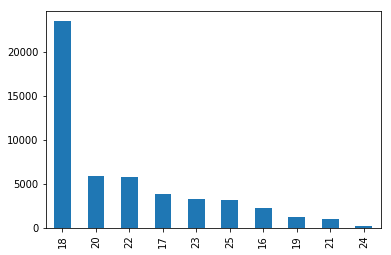

In [37]:
test['campaign_id'].value_counts().plot(kind='bar')
# These campaign id are different from the ones in train data.

#### EDA Campaign Data

In [38]:
campaign.isnull().sum()

campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64

In [39]:
print ("Number Of Unique Campaigns in the Campaign data:",campaign['campaign_id'].nunique())
# As mentioned in the competition the campaign data has campaign_id's of both Train and test data.

Number Of Unique Campaigns in the Campaign data: 28


In [40]:
campaign['campaign_type'].value_counts()
# There are only two unique campaign_type 

Y    22
X     6
Name: campaign_type, dtype: int64

In [41]:
# Creating different columns with respect to start
campaign['Campaign_Start_Day'] = campaign.start_date.dt.day
campaign['Campaign_Start_Month'] = campaign.start_date.dt.month
campaign['Campaign_Start_Year'] = campaign.start_date.dt.year
campaign['Campaign_Start_Quarter'] = campaign.start_date.dt.quarter
campaign['Campaign_Start_DayOfWeek'] = campaign.start_date.dt.dayofweek
campaign['Campaign_Start_MonthStart'] = campaign.start_date.dt.is_month_start
campaign['Campaign_Start_MonthEnd'] = campaign.start_date.dt.is_month_end
campaign['Campaign_Start_QuarterStart'] = campaign.start_date.dt.is_quarter_start
campaign['Campaign_Start_QuarterEnd'] = campaign.start_date.dt.is_quarter_end
campaign['Campaign_Start_YearStart'] = campaign.start_date.dt.is_year_start
campaign['Campaign_Start_YearEnd'] = campaign.start_date.dt.is_year_end

campaign['Campaign_End_Day'] = campaign.end_date.dt.day
campaign['Campaign_End_Month'] = campaign.end_date.dt.month
campaign['Campaign_End_Year'] = campaign.end_date.dt.year
campaign['Campaign_End_Quarter'] = campaign.end_date.dt.quarter
campaign['Campaign_End_DayOfWeek'] = campaign.end_date.dt.dayofweek
campaign['Campaign_End_MonthStart'] = campaign.end_date.dt.is_month_start
campaign['Campaign_End_MonthEnd'] = campaign.end_date.dt.is_month_end
campaign['Campaign_End_QuarterStart'] = campaign.end_date.dt.is_quarter_start
campaign['Campaign_End_QuarterEnd'] = campaign.end_date.dt.is_quarter_end
campaign['Campaign_End_YearStart'] = campaign.end_date.dt.is_year_start
campaign['Campaign_End_YearEnd'] = campaign.end_date.dt.is_year_end

Combining data and the campaign datasets to get additional details about campaign start date and end date into the training set

#### EDA Demographics data

In [42]:
demographics.shape

(760, 7)

In [43]:
demographics.isnull().sum()
# There are missing values in marital_status and no_of_children columns.

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [44]:
for col in demographics.columns:
    print ("Number of Unique Values in {} variable are:".format(col),demographics[col].nunique())

Number of Unique Values in customer_id variable are: 760
Number of Unique Values in age_range variable are: 6
Number of Unique Values in marital_status variable are: 2
Number of Unique Values in rented variable are: 2
Number of Unique Values in family_size variable are: 5
Number of Unique Values in no_of_children variable are: 3
Number of Unique Values in income_bracket variable are: 12


Text(0,0.5,'Count')

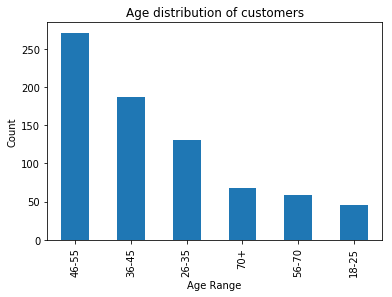

In [45]:
demographics['age_range'].value_counts().plot(kind='bar')
plt.title("Age distribution of customers")
plt.xlabel("Age Range")
plt.ylabel("Count")

Text(0,0.5,'Count')

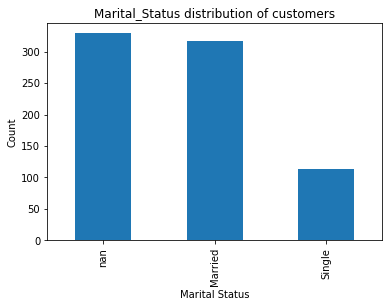

In [46]:
demographics['marital_status'].value_counts(dropna=False).plot(kind='bar')
plt.title("Marital_Status distribution of customers")
plt.xlabel("Marital Status")
plt.ylabel("Count")

Text(0,0.5,'Count')

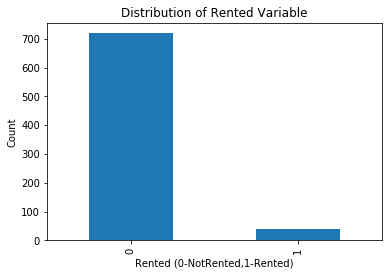

In [47]:
demographics['rented'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of Rented Variable")
plt.xlabel("Rented (0-NotRented,1-Rented)")
plt.ylabel("Count")

Text(0,0.5,'Count')

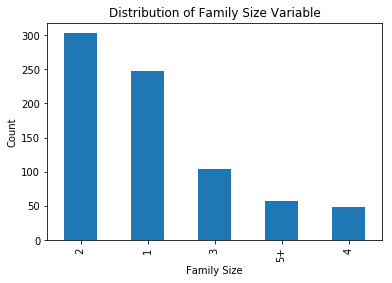

In [48]:
demographics['family_size'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of Family Size Variable")
plt.xlabel("Family Size")
plt.ylabel("Count")

Text(0,0.5,'Count')

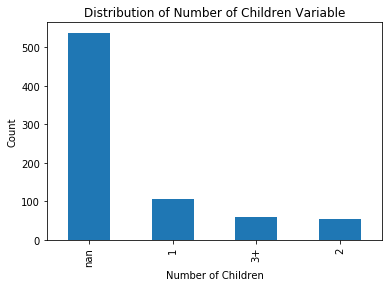

In [49]:
demographics['no_of_children'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of Number of Children Variable")
plt.xlabel("Number of Children")
plt.ylabel("Count")

Text(0,0.5,'Count')

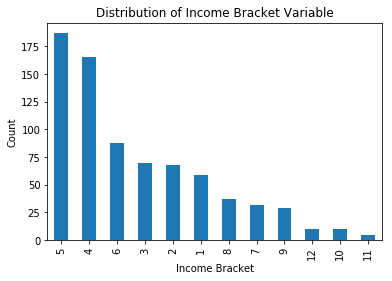

In [50]:
demographics['income_bracket'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of Income Bracket Variable")
plt.xlabel("Income Bracket")
plt.ylabel("Count")

In [51]:
demographics['marital_status'].fillna(demographics['marital_status'].value_counts(dropna=False).index[1],inplace=True)
demographics['no_of_children'].fillna(demographics['no_of_children'].value_counts(dropna=False).index[1],inplace=True)

In [52]:
demographics.isnull().sum()

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

In [53]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    760 non-null object
rented            760 non-null int64
family_size       760 non-null object
no_of_children    760 non-null object
income_bracket    760 non-null int64
dtypes: int64(3), object(4)
memory usage: 41.6+ KB


In [54]:
demographics['income_bracket'] = demographics['income_bracket'].astype("object")
demographics['rented'] = demographics['rented'].astype("object")

In [55]:
demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,1,4
1,6,46-55,Married,0,2,1,5
2,7,26-35,Married,0,3,1,3
3,8,26-35,Married,0,4,2,6
4,10,46-55,Single,0,1,1,5


#### EDA Mapping Data

In [56]:
mapping.shape

(92663, 2)

In [57]:
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
coupon_id    92663 non-null int64
item_id      92663 non-null int64
dtypes: int64(2)
memory usage: 1.4 MB


In [58]:
for col in mapping.columns:
    print ("Number of Unique Values in {} column in tranining data are:".format(col),mapping[col].nunique())

Number of Unique Values in coupon_id column in tranining data are: 1116
Number of Unique Values in item_id column in tranining data are: 36289


1. There are a total of 36289 unique item_ids.
2. Mapping data has a total of 1116 unique campaign_id's. 

#### EDA Transactions data

In [59]:
transactions.shape

(1324566, 7)

In [60]:
transactions.isnull().sum()

date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64

In [61]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null datetime64[ns]
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [62]:
transactions['customer_id'].nunique(), transactions['item_id'].nunique()

(1582, 74063)

In [63]:
transactions['selling_price'].describe()

count   1324566.00000
mean        114.60363
std         152.90530
min           0.36000
25%          49.16000
50%          78.01000
75%         124.31000
max       17809.64000
Name: selling_price, dtype: float64

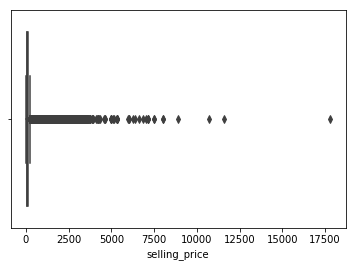

In [64]:
sns.boxplot(transactions['selling_price'])
# There are some values in the selling price that stand out from the rest.

In [65]:
lst = list(transactions[transactions['selling_price'] > 9000].index.values)
transactions.drop(lst,inplace=True)

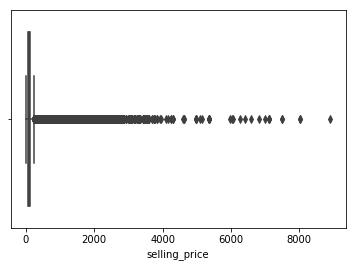

In [66]:
sns.boxplot(transactions['selling_price'])
# There are some values in the selling price that stand out from the rest.

In [67]:
transactions['other_discount'] = np.abs(transactions['other_discount'])
transactions['coupon_discount'] = np.abs(transactions['coupon_discount'])

transactions['MRP'] = transactions['selling_price']+transactions['other_discount']+transactions['coupon_discount']
transactions['other_discount_pct'] = (transactions['other_discount']/transactions['MRP'])*100
transactions['coupon_discount_pct'] = (transactions['coupon_discount']/transactions['MRP'])*100

In [68]:
transactions['transactions_Day'] = transactions.date.dt.day
transactions['transactions_Month'] = transactions.date.dt.month
transactions['transactions_Year'] = transactions.date.dt.year
transactions['transactions_Quarter'] = transactions.date.dt.quarter
transactions['transactions_DayOfWeek'] = transactions.date.dt.dayofweek

#### EDA Item Data

In [69]:
item.shape

(74066, 4)

In [70]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
item_id       74066 non-null int64
brand         74066 non-null int64
brand_type    74066 non-null object
category      74066 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [71]:
for col in item.columns:
    print ("Number of Unique Values in {} column in tranining data are:".format(col),item[col].nunique())

Number of Unique Values in item_id column in tranining data are: 74066
Number of Unique Values in brand column in tranining data are: 5528
Number of Unique Values in brand_type column in tranining data are: 2
Number of Unique Values in category column in tranining data are: 19


In [72]:
item['brand'].value_counts().head()

56      10480
686      1142
1        1091
4700      923
1262      906
Name: brand, dtype: int64

In [73]:
item['brand_type'].value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

Text(0,0.5,'Count')

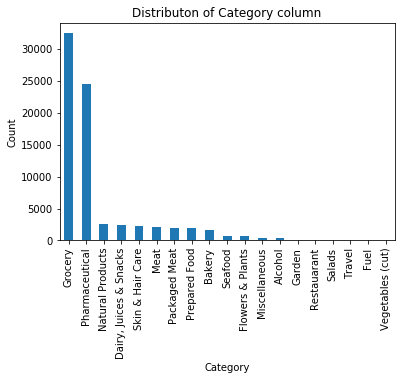

In [74]:
item['category'].value_counts().plot(kind='bar')
plt.title("Distributon of Category column")
plt.xlabel("Category")
plt.ylabel("Count")

#### Combining Datasets to get final data.

In [75]:
Submission = test[['id']]

test.drop('id',axis=1,inplace=True)
train.drop('id',axis=1,inplace=True)

y = train['redemption_status']
train.drop('redemption_status',axis=1,inplace=True)

len_train = len(train)
data = pd.concat([train,test],axis=0).reset_index(drop=True)

print ("Training Dataset Shape:",train.shape)
print ("Test Dataset Shape:",test.shape)
print ("Combined Dataset Shape:",data.shape)

Training Dataset Shape: (78369, 3)
Test Dataset Shape: (50226, 3)
Combined Dataset Shape: (128595, 3)


In [76]:
data.head()

,campaign_id,coupon_id,customer_id
0,13,27,1053
1,13,116,48
2,9,635,205
3,13,644,1050
4,8,1017,1489


In [77]:
# Combining train_test with campaign data on campaign_id column
data = pd.merge(left=data,right=campaign,left_on='campaign_id',right_on='campaign_id',how='left')
print ("train_test_campaign dataset shape:",data.shape)

train_test_campaign dataset shape: (128595, 28)


In [78]:
data.head()

,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,Campaign_Start_Day,Campaign_Start_Month,Campaign_Start_Year,Campaign_Start_Quarter,Campaign_Start_DayOfWeek,Campaign_Start_MonthStart,Campaign_Start_MonthEnd,Campaign_Start_QuarterStart,Campaign_Start_QuarterEnd,Campaign_Start_YearStart,Campaign_Start_YearEnd,Campaign_End_Day,Campaign_End_Month,Campaign_End_Year,Campaign_End_Quarter,Campaign_End_DayOfWeek,Campaign_End_MonthStart,Campaign_End_MonthEnd,Campaign_End_QuarterStart,Campaign_End_QuarterEnd,Campaign_End_YearStart,Campaign_End_YearEnd
0,13,27,1053,X,2013-05-19,2013-07-05,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False
1,13,116,48,X,2013-05-19,2013-07-05,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False
2,9,635,205,Y,2013-03-11,2013-04-12,11,3,2013,1,0,False,False,False,False,False,False,12,4,2013,2,4,False,False,False,False,False,False
3,13,644,1050,X,2013-05-19,2013-07-05,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False
4,8,1017,1489,X,2013-02-16,2013-04-05,16,2,2013,1,5,False,False,False,False,False,False,5,4,2013,2,4,False,False,False,False,False,False


In [79]:
data.drop(['start_date','end_date'],axis=1,inplace=True)

In [80]:
data = pd.merge(left=data,right=demographics,left_on='customer_id',right_on='customer_id',how='left')
data.shape

(128595, 32)

In [81]:
data.isnull().sum()

campaign_id                        0
coupon_id                          0
customer_id                        0
campaign_type                      0
Campaign_Start_Day                 0
Campaign_Start_Month               0
Campaign_Start_Year                0
Campaign_Start_Quarter             0
Campaign_Start_DayOfWeek           0
Campaign_Start_MonthStart          0
Campaign_Start_MonthEnd            0
Campaign_Start_QuarterStart        0
Campaign_Start_QuarterEnd          0
Campaign_Start_YearStart           0
Campaign_Start_YearEnd             0
Campaign_End_Day                   0
Campaign_End_Month                 0
Campaign_End_Year                  0
Campaign_End_Quarter               0
Campaign_End_DayOfWeek             0
Campaign_End_MonthStart            0
Campaign_End_MonthEnd              0
Campaign_End_QuarterStart          0
Campaign_End_QuarterEnd            0
Campaign_End_YearStart             0
Campaign_End_YearEnd               0
age_range                      53995
m

In [82]:
data['age_range'].fillna(data['age_range'].value_counts(dropna=False).index[1],inplace=True)
data['marital_status'].fillna(data['marital_status'].value_counts(dropna=False).index[0],inplace=True)
data['rented'].fillna(data['rented'].value_counts(dropna=False).index[0],inplace=True)
data['family_size'].fillna(data['family_size'].value_counts(dropna=False).index[1],inplace=True)
data['no_of_children'].fillna(data['no_of_children'].value_counts(dropna=False).index[0],inplace=True)
data['income_bracket'].fillna(data['income_bracket'].value_counts(dropna=False).index[1],inplace=True)

In [83]:
# Merging mapping and item data to get details about coupons.
coupon_item = pd.merge(item,mapping,left_on='item_id',right_on='item_id',how='inner')
coupon_item.shape

(92663, 5)

In [84]:
coupon_item.head()

,item_id,brand,brand_type,category,coupon_id
0,1,1,Established,Grocery,22
1,1,1,Established,Grocery,31
2,4,56,Local,Grocery,166
3,4,56,Local,Grocery,327
4,4,56,Local,Grocery,82


In [85]:
# Creating additional features
number_of_unique_item_id_per_coupon = coupon_item.groupby('coupon_id')['item_id'].nunique().to_dict()
data['number_of_unique_item_id_per_coupon'] = data['coupon_id'].map(number_of_unique_item_id_per_coupon)

number_of_unique_brands_per_coupon = coupon_item.groupby('coupon_id')['brand'].nunique().to_dict()
data['number_of_unique_brands_per_coupon'] = data['coupon_id'].map(number_of_unique_brands_per_coupon)

common_brand_per_coupon = coupon_item.groupby('coupon_id').brand.apply(lambda x: x.mode()[0]).to_dict()
data['common_brand_per_coupon'] = data['coupon_id'].map(common_brand_per_coupon)

number_of_unique_brand_types_per_coupon = coupon_item.groupby('coupon_id')['brand_type'].nunique().to_dict()
data['number_of_unique_brand_types_per_coupon'] = data['coupon_id'].map(number_of_unique_brand_types_per_coupon)

common_brand_type_per_coupon = coupon_item.groupby('coupon_id').brand_type.apply(lambda x: x.mode()[0]).to_dict()
data['common_brand_type_per_coupon'] = data['coupon_id'].map(common_brand_per_coupon)

number_of_unique_category_per_coupon = coupon_item.groupby('coupon_id')['category'].nunique().to_dict()
data['number_of_unique_category_per_coupon'] = data['coupon_id'].map(number_of_unique_category_per_coupon)

common_category_per_coupon = coupon_item.groupby('coupon_id').category.apply(lambda x: x.mode()[0]).to_dict()
data['common_category_per_coupon'] = data['coupon_id'].map(common_category_per_coupon)

In [86]:
# Merging transaction and item data to get details about coupons.
transactions_item = pd.merge(transactions,item,left_on='item_id',right_on='item_id',how='inner')
transactions_item['total_price'] = transactions_item['quantity']*transactions_item['selling_price']
transactions_item.shape

(1324563, 19)

In [87]:
transactions_item.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,MRP,other_discount_pct,coupon_discount_pct,transactions_Day,transactions_Month,transactions_Year,transactions_Quarter,transactions_DayOfWeek,brand,brand_type,category,total_price
0,2012-01-02,1501,26830,1,35.26000,10.69000,0.00000,45.95000,23.26442,0.00000,2,1,2012,1,0,56,Local,Natural Products,35.26000
1,2012-01-02,135,26830,1,35.26000,10.69000,0.00000,45.95000,23.26442,0.00000,2,1,2012,1,0,56,Local,Natural Products,35.26000
2,2012-01-02,464,26830,1,35.26000,10.69000,0.00000,45.95000,23.26442,0.00000,2,1,2012,1,0,56,Local,Natural Products,35.26000
3,2012-01-12,1185,26830,1,45.95000,0.00000,0.00000,45.95000,0.00000,0.00000,12,1,2012,1,3,56,Local,Natural Products,45.95000
4,2012-01-13,1140,26830,1,45.95000,0.00000,0.00000,45.95000,0.00000,0.00000,13,1,2012,1,4,56,Local,Natural Products,45.95000


In [88]:
# Generating new features
average_other_discount_pct_per_customer = transactions_item.groupby('customer_id').other_discount_pct.mean().to_dict()
data['average_other_discount_pct_per_customer'] = data['customer_id'].map(average_other_discount_pct_per_customer)

average_coupon_discount_pct_per_customer = transactions_item.groupby('customer_id').coupon_discount_pct.mean().to_dict()
data['average_coupon_discount_pct_per_customer'] = data['customer_id'].map(average_coupon_discount_pct_per_customer)

number_of_unique_item_id_purchased_per_coupon = transactions_item.groupby('customer_id')['item_id'].nunique().to_dict()
data['number_of_unique_item_id_purchased_per_coupon'] = data['coupon_id'].map(number_of_unique_item_id_purchased_per_coupon)

commonly_purchased_item_per_customer = transactions_item.groupby('customer_id').item_id.apply(lambda x: x.mode()[0]).to_dict()
data['commonly_purchased_item_per_customer'] = data['customer_id'].map(commonly_purchased_item_per_customer)

total_quantity_purchased_per_customer = transactions_item.groupby('customer_id')['quantity'].sum().to_dict()
data['total_quantity_purchased_per_customer'] = data['customer_id'].map(total_quantity_purchased_per_customer)

total_amount_per_customer = transactions_item.groupby('customer_id')['total_price'].sum().to_dict()
data['total_amount_per_customer'] = data['customer_id'].map(total_quantity_purchased_per_customer)

average_amount_per_customer = transactions_item.groupby('customer_id').total_price.mean().to_dict()
data['average_amount_per_customer'] = data['customer_id'].map(average_amount_per_customer)

median_amount_per_customer = transactions_item.groupby('customer_id').total_price.median().to_dict()
data['median_amount_per_customer'] = data['customer_id'].map(median_amount_per_customer)

total_other_discount_per_customer = transactions_item.groupby('customer_id').other_discount.sum().to_dict()
data['total_other_discount_per_customer'] = data['customer_id'].map(total_other_discount_per_customer)

average_other_discount_per_customer = transactions_item.groupby('customer_id').other_discount.mean().to_dict()
data['average_other_discount_per_customer'] = data['customer_id'].map(average_other_discount_per_customer)

median_other_discount_per_customer = transactions_item.groupby('customer_id').other_discount.median().to_dict()
data['median_other_discount_per_customer'] = data['customer_id'].map(median_other_discount_per_customer)

total_coupon_discount_per_customer = transactions_item.groupby('customer_id').coupon_discount.sum().to_dict()
data['total_coupon_discount_per_customer'] = data['customer_id'].map(total_coupon_discount_per_customer)

average_coupon_discount_per_customer = transactions_item.groupby('customer_id').coupon_discount.mean().to_dict()
data['average_coupon_discount_per_customer'] = data['customer_id'].map(average_coupon_discount_per_customer)

median_coupon_discount_per_customer = transactions_item.groupby('customer_id').coupon_discount.median().to_dict()
data['median_coupon_discount_per_customer'] = data['customer_id'].map(median_coupon_discount_per_customer)

customer_since_how_many_years = transactions_item.groupby('customer_id')['transactions_Year'].nunique().to_dict()
data['customer_since_how_many_years'] = data['customer_id'].map(customer_since_how_many_years)

most_shopped_day_per_customer = transactions_item.groupby('customer_id')['transactions_Day'].apply(lambda x: x.mode()[0]).to_dict()
data['most_shopped_day_per_customer'] = data['customer_id'].map(most_shopped_day_per_customer)

most_shopped_dayofweek_per_customer = transactions_item.groupby('customer_id')['transactions_DayOfWeek'].apply(lambda x: x.mode()[0]).to_dict()
data['most_shopped_dayofweek_per_customer'] = data['customer_id'].map(most_shopped_dayofweek_per_customer)

most_shopped_month_per_customer = transactions_item.groupby('customer_id')['transactions_Month'].apply(lambda x: x.mode()[0]).to_dict()
data['most_shopped_month_per_customer'] = data['customer_id'].map(most_shopped_month_per_customer)

#####################################################################################################################

number_of_unique_item_id_per_customer = transactions_item.groupby('customer_id')['item_id'].nunique().to_dict()
data['number_of_unique_item_id_per_customer'] = data['customer_id'].map(number_of_unique_item_id_per_customer)

number_of_unique_brands_per_customer = transactions_item.groupby('customer_id')['brand'].nunique().to_dict()
data['number_of_unique_brands_per_customer'] = data['customer_id'].map(number_of_unique_brands_per_customer)

common_brand_per_customer = transactions_item.groupby('customer_id').brand.apply(lambda x: x.mode()[0]).to_dict()
data['common_brand_per_customer'] = data['customer_id'].map(common_brand_per_customer)

number_of_unique_brand_types_per_customer = transactions_item.groupby('customer_id')['brand_type'].nunique().to_dict()
data['number_of_unique_brand_types_per_customer'] = data['customer_id'].map(number_of_unique_brand_types_per_customer)

common_brand_type_per_customer = transactions_item.groupby('customer_id').brand_type.apply(lambda x: x.mode()[0]).to_dict()
data['common_brand_type_per_customer'] = data['customer_id'].map(common_brand_type_per_customer)

number_of_unique_category_per_customer = transactions_item.groupby('customer_id')['category'].nunique().to_dict()
data['number_of_unique_category_per_customer'] = data['customer_id'].map(number_of_unique_category_per_customer)

common_category_per_customer = transactions_item.groupby('customer_id').category.apply(lambda x: x.mode()[0]).to_dict()
data['common_category_per_customer'] = data['customer_id'].map(common_category_per_customer)

In [89]:
data.shape

(128595, 64)

In [90]:
data.head()

,campaign_id,coupon_id,customer_id,campaign_type,Campaign_Start_Day,Campaign_Start_Month,Campaign_Start_Year,Campaign_Start_Quarter,Campaign_Start_DayOfWeek,Campaign_Start_MonthStart,Campaign_Start_MonthEnd,Campaign_Start_QuarterStart,Campaign_Start_QuarterEnd,Campaign_Start_YearStart,Campaign_Start_YearEnd,Campaign_End_Day,Campaign_End_Month,Campaign_End_Year,Campaign_End_Quarter,Campaign_End_DayOfWeek,Campaign_End_MonthStart,Campaign_End_MonthEnd,Campaign_End_QuarterStart,Campaign_End_QuarterEnd,Campaign_End_YearStart,Campaign_End_YearEnd,age_range,marital_status,rented,family_size,no_of_children,income_bracket,number_of_unique_item_id_per_coupon,number_of_unique_brands_per_coupon,common_brand_per_coupon,number_of_unique_brand_types_per_coupon,common_brand_type_per_coupon,number_of_unique_category_per_coupon,common_category_per_coupon,average_other_discount_pct_per_customer,average_coupon_discount_pct_per_customer,number_of_unique_item_id_purchased_per_coupon,commonly_purchased_item_per_customer,total_quantity_purchased_per_customer,total_amount_per_customer,average_amount_per_customer,median_amount_per_customer,total_other_discount_per_customer,average_other_discount_per_customer,median_other_discount_per_customer,total_coupon_discount_per_customer,average_coupon_discount_per_customer,median_coupon_discount_per_customer,customer_since_how_many_years,most_shopped_day_per_customer,most_shopped_dayofweek_per_customer,most_shopped_month_per_customer,number_of_unique_item_id_per_customer,number_of_unique_brands_per_customer,common_brand_per_customer,number_of_unique_brand_types_per_customer,common_brand_type_per_customer,number_of_unique_category_per_customer,common_category_per_customer
0,13,27,1053,X,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False,46-55,Married,0.00000,1,1,5.00000,125,2,1105,1,1105,1,Grocery,14.87907,0.11216,866,14458,105551,105551,224818.62939,108.99000,10282.37000,33.16894,3.56000,89.05000,0.28726,0.00000,2,11,2,5,208,84,56,2,Established,8,Grocery
1,13,116,48,X,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False,36-45,Married,0.00000,2,1,3.00000,3,1,56,1,56,1,Grocery,15.14790,0.44178,345,23932,12143,12143,32536.28403,106.50000,10664.18000,27.69917,7.12000,1237.79000,3.21504,0.00000,2,4,5,6,244,102,56,2,Established,12,Grocery
2,9,635,205,Y,11,3,2013,1,0,False,False,False,False,False,False,12,4,2013,2,4,False,False,False,False,False,False,46-55,Married,0.00000,2,1,7.00000,67,1,560,1,560,1,Pharmaceutical,10.74744,1.46366,274,13294,1351,1351,187.11419,106.50000,17261.79000,17.79566,0.00000,2145.72000,2.21208,0.00000,2,27,2,3,533,186,56,2,Established,11,Grocery
3,13,644,1050,X,19,5,2013,2,6,False,False,False,False,False,False,5,7,2013,3,4,False,False,False,False,False,False,46-55,Married,0.00000,2,1,5.00000,4,1,611,1,611,1,Grocery,13.56198,0.09923,272,9281,306,306,129.97190,81.57000,3947.37000,16.65557,1.42000,178.10000,0.75148,0.00000,2,9,4,8,216,73,56,2,Established,8,Grocery
4,8,1017,1489,X,16,2,2013,1,5,False,False,False,False,False,False,5,4,2013,2,4,False,False,False,False,False,False,46-55,Married,0.00000,2,1,3.00000,32,1,1558,1,1558,1,Grocery,13.46946,0.34815,1113,10673,139063,139063,222981.57407,106.50000,11534.90000,20.52473,0.18000,265.01000,0.47155,0.00000,2,2,4,5,327,106,56,2,Established,8,Grocery


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128595 entries, 0 to 128594
Data columns (total 64 columns):
campaign_id                                      128595 non-null int64
coupon_id                                        128595 non-null int64
customer_id                                      128595 non-null int64
campaign_type                                    128595 non-null object
Campaign_Start_Day                               128595 non-null int64
Campaign_Start_Month                             128595 non-null int64
Campaign_Start_Year                              128595 non-null int64
Campaign_Start_Quarter                           128595 non-null int64
Campaign_Start_DayOfWeek                         128595 non-null int64
Campaign_Start_MonthStart                        128595 non-null bool
Campaign_Start_MonthEnd                          128595 non-null bool
Campaign_Start_QuarterStart                      128595 non-null bool
Campaign_Start_QuarterEnd              

In [92]:
# dropping the id variables 
id_vars = data[['campaign_id']]
data.drop(id_vars,axis=1,inplace=True)

In [93]:
categorical_columns = ['coupon_id','customer_id','campaign_type','Campaign_Start_Day','Campaign_Start_Month','Campaign_Start_Year','Campaign_Start_Quarter',
                      'Campaign_Start_DayOfWeek','Campaign_End_Day','Campaign_End_Month','Campaign_End_Year','Campaign_End_Quarter',
                      'Campaign_End_DayOfWeek','common_brand_per_coupon','common_brand_type_per_coupon','common_category_per_coupon',
                      'commonly_purchased_item_per_customer','most_shopped_day_per_customer','most_shopped_dayofweek_per_customer',
                      'most_shopped_month_per_customer','common_brand_per_customer','common_brand_type_per_customer']
for col in categorical_columns:
    data[col] = data[col].astype("object")

In [94]:
# Categorical boolean mask
categorical_feature_mask = data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))

In [95]:
train = data.iloc[:len_train,:]
test = data.iloc[len_train:,:]

#### Removing Highly Correlated Variables

In [96]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9
# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

Wall time: 889 ms


In [97]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,coupon_id,customer_id,campaign_type,Campaign_Start_Day,Campaign_Start_Month,Campaign_Start_Year,Campaign_Start_Quarter,Campaign_Start_DayOfWeek,Campaign_Start_MonthStart,Campaign_Start_MonthEnd,Campaign_Start_QuarterStart,Campaign_Start_QuarterEnd,Campaign_Start_YearStart,Campaign_Start_YearEnd,Campaign_End_Day,Campaign_End_Month,Campaign_End_Year,Campaign_End_Quarter,Campaign_End_DayOfWeek,Campaign_End_MonthStart,Campaign_End_MonthEnd,Campaign_End_QuarterStart,Campaign_End_QuarterEnd,Campaign_End_YearStart,Campaign_End_YearEnd,age_range,marital_status,rented,family_size,no_of_children,income_bracket,number_of_unique_item_id_per_coupon,number_of_unique_brands_per_coupon,common_brand_per_coupon,number_of_unique_brand_types_per_coupon,common_brand_type_per_coupon,number_of_unique_category_per_coupon,common_category_per_coupon,average_other_discount_pct_per_customer,average_coupon_discount_pct_per_customer,number_of_unique_item_id_purchased_per_coupon,commonly_purchased_item_per_customer,total_quantity_purchased_per_customer,total_amount_per_customer,average_amount_per_customer,median_amount_per_customer,total_other_discount_per_customer,average_other_discount_per_customer,median_other_discount_per_customer,total_coupon_discount_per_customer,average_coupon_discount_per_customer,median_coupon_discount_per_customer,customer_since_how_many_years,most_shopped_day_per_customer,most_shopped_dayofweek_per_customer,most_shopped_month_per_customer,number_of_unique_item_id_per_customer,number_of_unique_brands_per_customer,common_brand_per_customer,number_of_unique_brand_types_per_customer,common_brand_type_per_customer,number_of_unique_category_per_customer,common_category_per_customer
coupon_id,nan,0.00755,0.18309,0.05841,0.10991,0.14160,0.13476,0.14578,nan,nan,nan,nan,nan,nan,0.13877,0.01408,0.11224,0.04535,0.03175,0.00966,0.08420,nan,nan,nan,nan,0.01972,0.00317,0.00993,0.02026,0.02124,0.00560,0.15723,0.14800,0.60684,0.20108,0.60684,0.15753,0.11716,0.00160,0.00611,0.03771,0.00876,0.01197,0.01197,0.00152,0.00281,0.03078,0.00362,0.01016,0.01722,0.00553,nan,0.00598,0.00153,0.00049,0.01183,0.03613,0.03029,0.00705,nan,0.00377,0.02147,0.00167
customer_id,nan,nan,0.02119,0.00742,0.00888,0.00675,0.00514,0.00262,nan,nan,nan,nan,nan,nan,0.01133,0.00145,0.00137,0.00689,0.02338,0.00124,0.01709,nan,nan,nan,nan,0.04481,0.02631,0.00817,0.01213,0.00085,0.06419,0.00351,0.00338,0.00034,0.00324,0.00034,0.00163,0.01246,0.02205,0.02917,0.00094,0.00551,0.02328,0.02328,0.00710,0.01586,0.11179,0.04046,0.03600,0.05158,0.01559,nan,0.01734,0.02598,0.03169,0.00438,0.11772,0.12147,0.01611,nan,0.02635,0.09193,0.04915
campaign_type,nan,nan,nan,0.40220,0.03381,0.07639,0.10080,0.65729,nan,nan,nan,nan,nan,nan,0.58204,0.02776,0.15629,0.11434,0.16215,0.04811,0.38190,nan,nan,nan,nan,0.05118,0.02593,0.03305,0.06153,0.05669,0.05107,0.05019,0.05327,0.10518,0.07848,0.10518,0.05099,0.07898,0.03979,0.03329,0.02766,0.02931,0.06122,0.06122,0.01753,0.02835,0.10484,0.02715,0.01006,0.05010,0.01806,nan,0.00696,0.00510,0.02848,0.01522,0.13009,0.13434,0.01582,nan,0.01919,0.07876,0.01239
Campaign_Start_Day,nan,nan,nan,nan,0.10640,0.20850,0.04867,0.18975,nan,nan,nan,nan,nan,nan,0.43859,0.11474,0.45290,0.01181,0.15927,0.07555,0.45404,nan,nan,nan,nan,0.02017,0.03515,0.00393,0.01106,0.01025,0.04869,0.04380,0.03568,0.07595,0.02813,0.07595,0.04333,0.04689,0.03802,0.03773,0.00154,0.01080,0.02051,0.02051,0.03774,0.04562,0.03654,0.00445,0.01450,0.00745,0.03627,nan,0.04457,0.00806,0.03146,0.01822,0.03869,0.00815,0.01669,nan,0.02099,0.00496,0.00734
Campaign_Start_Month,nan,nan,nan,nan,nan,0.84790,0.98495,0.30225,nan,nan,nan,nan,nan,nan,0.34021,0.22118,0.45893,0.18871,0.16414,0.03886,0.36719,nan,nan,nan,nan,0.02219,0.00526,0.00432,0.02501,0.01216,0.00923,0.02199,0.02714,0.03663,0.00675,0.03663,0.04143,0.10450,0.03495,0.01427,0.04177,0.03334,0.02267,0.02267,0.00060,0.02415,0.01351,0.02854,0.03907,0.01714,0.02096,nan,0.03608,0.01470,0.01007,0.08768,0.00643,0.01393,0.04502,nan,0.01336,0.00303,0.00877


In [98]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

There are 6 columns to remove.
Following columns can be dropped ['Campaign_Start_Quarter', 'Campaign_End_Quarter', 'common_brand_type_per_coupon', 'total_amount_per_customer', 'average_coupon_discount_per_customer', 'number_of_unique_brands_per_customer']


In [99]:
train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

C:\Users\m1013523\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [100]:
# Standardizing some features
scaled_features_train = train.copy()
scaled_features_test = test.copy()

col_names = ['average_other_discount_pct_per_customer','average_coupon_discount_pct_per_customer',
            'average_amount_per_customer','median_amount_per_customer','total_other_discount_per_customer','average_other_discount_per_customer',
            'median_other_discount_per_customer','total_coupon_discount_per_customer']

features_train = scaled_features_train[col_names]
features_test = scaled_features_test[col_names]

scaler_train = StandardScaler().fit(features_train.values)
scaler_test = StandardScaler().fit(features_test.values)

features_train = scaler_train.transform(features_train.values)
features_test = scaler_test.transform(features_test.values)

scaled_features_train[col_names] = features_train
scaled_features_test[col_names] = features_test

train = scaled_features_train
test = scaled_features_test

X = train

In [101]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(ratio='majority')
X_Resample, y_Resample = tl.fit_sample(X, y)

C:\Users\m1013523\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [102]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for train_index,test_index in kf.split(X_Resample,y_Resample):
    X_Train,X_Valid = X.loc[train_index],X.loc[test_index]
    y_Train,y_Valid = y.loc[train_index],y.loc[test_index]
print (X_Train.shape)
print (y_Train.shape)
print (X_Valid.shape)
print (y_Valid.shape)

(62404, 57)
(62404,)
(15600, 57)
(15600,)


In [103]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=42,class_weight='balanced',n_jobs=-1,verbose=1)
params = {"max_depth":[3,4,5,6,7,-1],
          "learning_rate":[0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0.5,1,2],
          "reg_lambda":[0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,300,50))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=10,scoring='roc_auc')
random_search.fit(X_Train,y_Train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=42, reg_alph...
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, -1],
                

In [104]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                colsample_bytree=0.5, importance_type='split',
                learning_rate=0.05, max_depth=5, min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=3, min_split_gain=0.0,
                n_estimators=200, n_jobs=-1, num_leaves=7, objective='binary',
                random_state=42, reg_alpha=2, reg_lambda=1, silent=True,
                subsample=0.6, subsample_for_bin=200000, subsample_freq=0,
                verbose=1),
 {'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_data_in_leaf': 3,
  'n_estimators': 200,
  'num_leaves': 7,
  'reg_alpha': 2,
  'reg_lambda': 1,
  'subsample': 0.6},
 0.9360848623921941)

In [ ]:
#Submission['redemption_status'] = random_search.best_estimator_.predict_proba(test)[:,1]
Submission.to_csv("Submission_22.csv",index=None)

In [ ]:
ser = pd.Series(random_search.best_estimator_.feature_importances_,X_Train.columns).sort_values()
lst = list(ser[ser > 0].index)
print (lst)
print (len(lst))

In [ ]:
"""
X_Train = X_Train[lst]
X_Valid = X_Valid[lst]
test = test[lst]

clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=42,class_weight='balanced',n_jobs=-1,verbose=1)
params = {"max_depth":[3,4,5,6,7,-1],
          "learning_rate":[0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0.5,1,2],
          "reg_lambda":[0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,300,50))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=10,scoring='roc_auc')
random_search.fit(X_Train,y_Train)"""

In [ ]:
#random_search.best_estimator_,random_search.best_params_,random_search.best_score_

In [ ]:
#Submission['redemption_status'] = random_search.best_estimator_.predict_proba(test)[:,1]
#Submission.to_csv("Submission_22.csv",index=None)